In [1]:
from environments.utils import create_data
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
import torch
from environments.environment import SP500TradingEnv

In [2]:
sp500_df_train, sp500_df_test = create_data(scale_to_std=False, scale_min_max=True)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_g

## Defining the autoencoder

In [7]:
class TimeSeriesAutoEncoder(torch.nn.Module):
    def __init__(self, matrix_shape: Tuple[int, int], hidden_sizes: List[int]):
        super(TimeSeriesAutoEncoder, self).__init__()
        self.matrix_shape = matrix_shape
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(matrix_shape[0] * matrix_shape[1], hidden_sizes[0]),
        )
        # iterate through the hidden sizes and create a linear layer for each
        for i in range(1, len(hidden_sizes)):
            self.encoder.add_module(f'linear_{i}', torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.decoder = torch.nn.Sequential()
        # iterate through the hidden sizes backwards and create a linear layer for each
        for i in range(len(hidden_sizes)-1, 0, -1):
            self.decoder.add_module(f'linear_{i + len(hidden_sizes)}', torch.nn.Linear(hidden_sizes[i], hidden_sizes[i-1]))
        # add the final linear layer to decode the data back to the original shape
        self.decoder.add_module(f'linear_{2 * len(hidden_sizes)}', torch.nn.Linear(hidden_sizes[0], matrix_shape[0] * matrix_shape[1]))
    def forward(self, x):
        # flatten the input
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        # reshape the output
        x = x.view(x.size(0), *self.matrix_shape)
        return x

## Training autoencoder on SP500 training data

In [8]:
def train_autoencoder(model, train_loader, test_loader, optimizer, criterion, epochs, device='cuda'):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {train_loss}')
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                output = model(data)
                test_loss += criterion(output, data).item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print(f'Test set loss after epoch {epoch}: {test_loss}')
    return train_losses, test_losses

### Training the autoencoder
In the different experiments we have picked the best architecture for the autoencoder. We will resuse this architecture for the current experiment.

In [9]:
# create window dataloader from sp500_df_tech_indicators_time_enc using pytorch
import torch
from torch.utils.data import Dataset, DataLoader
# define class for window dataset
class WindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.window_size = window_size
    def __len__(self):
        return len(self.data) - self.window_size
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        window = self.data[idx:idx+self.window_size]
        return window

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
window_size = 60
matrix_shape = (window_size, sp500_df_train.shape[1])
train_dataset_60 = WindowDataset(sp500_df_train, window_size)
test_dataset_60 = WindowDataset(sp500_df_test, window_size)
train_loader_60 = DataLoader(train_dataset_60, batch_size=batch_size, shuffle=False)
test_loader_60 = DataLoader(test_dataset_60, batch_size=batch_size, shuffle=False)
hidden_sizes = [2048, 1024, 512, 256]
model_60_3_layers = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_60_3_layers.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()
epochs = 1600
train_losses_60_3_layers, test_losses_60_3_layers = train_autoencoder(model_60_3_layers, train_loader_60, test_loader_60, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0006089387670594166
Test set loss after epoch 1: 0.0006252649155530063
====> Epoch: 2 Average loss: 0.0004121143377138308
Test set loss after epoch 2: 0.0006906259079258163
====> Epoch: 3 Average loss: 0.00029529041718319476
Test set loss after epoch 3: 0.0005702012281209547
====> Epoch: 4 Average loss: 0.0002073328618031292
Test set loss after epoch 4: 0.0005043251538888905
====> Epoch: 5 Average loss: 0.00014946119040334398
Test set loss after epoch 5: 0.0004895403211520723
====> Epoch: 6 Average loss: 0.00013931469122150663
Test set loss after epoch 6: 0.0004911335007042361
====> Epoch: 7 Average loss: 0.00013666234619907124
Test set loss after epoch 7: 0.0004698140447719601
====> Epoch: 8 Average loss: 0.00013295760379286795
Test set loss after epoch 8: 0.0003749473787923349
====> Epoch: 9 Average loss: 0.00011671072459548679
Test set loss after epoch 9: 0.000202057448819438
====> Epoch: 10 Average loss: 0.000113268956431218
Test set loss after epoch 

In [11]:
# # extract the encoder part of the autoencoder
encoder_60_4_layers = model_60_3_layers.encoder
# # # save the encoder
torch.save(encoder_60_4_layers,  'encoder_60_4_layers.pt')
# load the encoder
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder_60_4_layers = torch.load('encoder_60_4_layers.pt')
# move the encoder to the gpu
encoder_60_3_layers = encoder_60_4_layers.to(device)

In [12]:
# get not scaled data
sp500_df_train_not_scaled, sp500_df_test_not_scaled = create_data(scale_to_std=False, scale_min_max=False)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_g

In [13]:
from torch import nn
import gym
import numpy as np
class SP500TradingEnvAutoencoder(SP500TradingEnv):
    def __init__(self, sp500_df_observations, sp500_df_real_prices, window_len=10, encoder:     nn.Module= None, device: str = 'cuda'):
        super().__init__(sp500_df_observations, sp500_df_real_prices, window_len)
        self.encoder = encoder
        self.device = device
        self.representations = self.calculate_representations()
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(int(self.representations[0].shape[0]),), dtype=np.float32)

    def calculate_representations(self) -> List[torch.tensor]:
        values_on_gpu = torch.tensor(self.sp500_df_features.values, dtype=torch.float32).to(self.device)
        return [torch.flatten(self.encoder(values_on_gpu[tick: tick + self.window_len].reshape(1, self.window_len * self.features))) for tick in range(0, self.end_tick + 1)]

    def get_observation(self):
        return self.representations[self.episode_tick].to('cpu').detach().numpy()

In [14]:
# create environment with the encoder
env = SP500TradingEnvAutoencoder(sp500_df_train, sp500_df_train_not_scaled, window_len=60, encoder=encoder_60_3_layers, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [15]:
from stable_baselines3 import PPO

model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 519  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.56e+03     |
|    ep_rew_mean          | 0.39         |
| time/                   |              |
|    fps                  | 433          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0090032015 |
|    clip_fraction        | 0.0482       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -4.96        |
|    learning_rate        | 0.0003       |
|    lo

In [16]:
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(env.end_tick):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render()

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 3
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 4
Portfolio value: [1.0036474]
SP500: [0.8176516]
Cash: [0.18599582]
Done: False
Episode tick: 5
Portfolio value: [1.0036474]
SP500: [0.]
Cash: [1.0036474]
Done: False
Episode tick: 6
Portfolio value: [1.0055096]
SP500: [0.31374466]
Cash: [0.691765]
Done: False
Episode tick: 7
Portfolio value: [1.0055096]
SP500: [0.]
Cash: [1.0055096]
Done: False
Episode tick: 8
Portfolio value: [1.0055096]
SP500: [0.]
Cash: [1.0055096]
Done: False
Episode tick: 9
Portfolio value: [1.0110854]
SP500: [1.0110854]
Cash: [0.]
Done: False
Episode tick: 10
Portfolio value: [1.0110854]
SP500: [0.]
Cash: [1.0110854]
Done: False
Episode tick: 11
Portfolio value: [1.0009727]
SP500: [1.0009727]
Cash: [0.]
Done: False
Episode tick: 12
Portfolio value: [1.0009727]
SP500: [0.]
Cash: [1.0

In [17]:
# create environment with the encoder and test data
test_env = SP500TradingEnvAutoencoder(sp500_df_test, sp500_df_test_not_scaled, window_len=60, encoder=encoder_60_4_layers, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [18]:
# test the model
obs = test_env.reset()
for i in range(test_env.end_tick):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 3
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 4
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 5
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 6
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 7
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 8
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 9
Portfolio value: [1.0001802]
SP500: [0.04038103]
Cash: [0.9597992]
Done: False
Episode tick: 10
Portfolio value: [1.0009604]
SP500: [0.15077144]
Cash: [0.850189]
Done: False
Episode tick: 11
Portfolio value: [1.0009604]
SP500: [0.]
Cash: [1.0009604]
Done: False
Episode tick: 12
Portfolio value: [1.0009604]
SP500: [0.]
Cash: [1.0009604]
Done: False
Episode tick: 13
Portfolio value: [1.0009604]
SP50

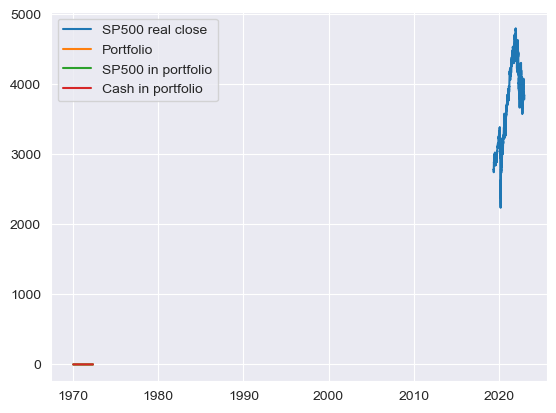

In [19]:
test_env.plot_portfolio_and()

In [15]:
# get in cash and in sp500 from test env
in_cash, in_sp500 = test_env.in_cash, test_env.in_sp500
# dump the values into json
import json
with open('test_env_data.json', 'w') as f:
    json.dump({"sp500": [float(val) for val in in_sp500], "cash": [float(val) for val in in_cash]}, f)

### Try training the PPO for less time to avoid overfitting

In [20]:
model_less_time = PPO('MlpPolicy', env, verbose=1)
model_less_time.learn(total_timesteps=50000)



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 556  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.56e+03    |
|    ep_rew_mean          | 0.359       |
| time/                   |             |
|    fps                  | 443         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008237472 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -7.46       |
|    learning_rate        | 0.0003      |
|    loss              

AttributeError: 'DummyVecEnv' object has no attribute 'end_tick'

In [22]:
vec_env = model_less_time.get_env()
obs = vec_env.reset()
for i in range(env.end_tick - 1):
    action, _states = model_less_time.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render()

Episode tick: 1
Portfolio value: [0.99930584]
SP500: [0.99930584]
Cash: [0.]
Done: False
Episode tick: 2
Portfolio value: [0.9928137]
SP500: [0.9928137]
Cash: [0.]
Done: False
Episode tick: 3
Portfolio value: [0.99563265]
SP500: [0.99563265]
Cash: [0.]
Done: False
Episode tick: 4
Portfolio value: [0.99563265]
SP500: [0.]
Cash: [0.99563265]
Done: False
Episode tick: 5
Portfolio value: [0.99749964]
SP500: [0.82489395]
Cash: [0.1726057]
Done: False
Episode tick: 6
Portfolio value: [0.99982846]
SP500: [0.39235544]
Cash: [0.607473]
Done: False
Episode tick: 7
Portfolio value: [0.9980493]
SP500: [0.21142125]
Cash: [0.78662807]
Done: False
Episode tick: 8
Portfolio value: [0.9980578]
SP500: [0.9980578]
Cash: [0.]
Done: False
Episode tick: 9
Portfolio value: [1.0035923]
SP500: [1.0035923]
Cash: [0.]
Done: False
Episode tick: 10
Portfolio value: [0.9917884]
SP500: [0.9917884]
Cash: [0.]
Done: False
Episode tick: 11
Portfolio value: [0.9908119]
SP500: [0.09666024]
Cash: [0.8941516]
Done: False
E

In [23]:
# test the model
obs = test_env.reset()
for i in range(test_env.end_tick):
    action, _states = model_less_time.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()

Episode tick: 1
Portfolio value: [0.9989475]
SP500: [0.3850186]
Cash: [0.6139289]
Done: False
Episode tick: 2
Portfolio value: [0.9922093]
SP500: [0.29994333]
Cash: [0.692266]
Done: False
Episode tick: 3
Portfolio value: [0.9922093]
SP500: [0.]
Cash: [0.9922093]
Done: False
Episode tick: 4
Portfolio value: [0.9922093]
SP500: [0.]
Cash: [0.9922093]
Done: False
Episode tick: 5
Portfolio value: [0.99356896]
SP500: [0.14728661]
Cash: [0.84628236]
Done: False
Episode tick: 6
Portfolio value: [0.9962162]
SP500: [0.54482913]
Cash: [0.45138705]
Done: False
Episode tick: 7
Portfolio value: [0.9962162]
SP500: [0.]
Cash: [0.9962162]
Done: False
Episode tick: 8
Portfolio value: [0.9962162]
SP500: [0.]
Cash: [0.9962162]
Done: False
Episode tick: 9
Portfolio value: [0.9962162]
SP500: [0.]
Cash: [0.9962162]
Done: False
Episode tick: 10
Portfolio value: [0.9962162]
SP500: [0.]
Cash: [0.9962162]
Done: False
Episode tick: 11
Portfolio value: [0.99591756]
SP500: [0.54904926]
Cash: [0.4468683]
Done: False

Training the model for less iterations did not provide any improvement. The model still overfits and performs worse on the test data.

### Try training the autoencoder to squeeze the data into 128 dimensions

In [24]:
hidden_sizes_128 = [2048, 1025, 512, 128]
model_60_3_layers_128 = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes_128).to(device)
optimizer = torch.optim.Adam(model_60_3_layers_128.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()
epochs = 1600
train_losses_60_3_layers_128, test_losses_60_3_layers_128 = train_autoencoder(model_60_3_layers_128, train_loader_60, test_loader_60, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0006088709101231411
Test set loss after epoch 1: 0.0006253208916682702
====> Epoch: 2 Average loss: 0.00040901162871708374
Test set loss after epoch 2: 0.0006894466842149759
====> Epoch: 3 Average loss: 0.0002913431689879041
Test set loss after epoch 3: 0.0005660157875018249
====> Epoch: 4 Average loss: 0.00020001380255928747
Test set loss after epoch 4: 0.0004894028460648716
====> Epoch: 5 Average loss: 0.00014803182165421688
Test set loss after epoch 5: 0.0004857277614201959
====> Epoch: 6 Average loss: 0.00013927205107211398
Test set loss after epoch 6: 0.00047907880655849417
====> Epoch: 7 Average loss: 0.00013530880472007156
Test set loss after epoch 7: 0.00042812259913968645
====> Epoch: 8 Average loss: 0.00012604473602950708
Test set loss after epoch 8: 0.0002564448344278223
====> Epoch: 9 Average loss: 0.00011178736881207671
Test set loss after epoch 9: 0.00019683581122682115
====> Epoch: 10 Average loss: 0.00010198892818556892
Test set loss after

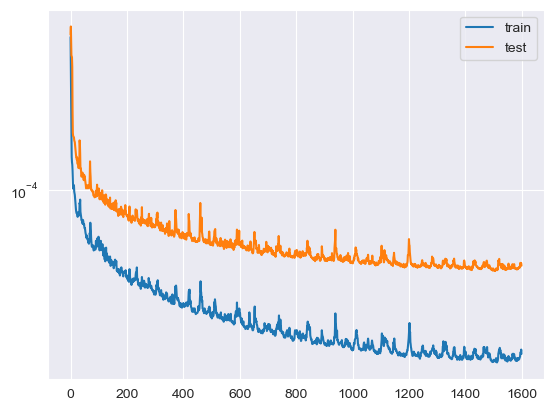

In [25]:
# plot losses in the training and test set on the log scale
plt.plot(train_losses_60_3_layers_128, label='train')
plt.plot(test_losses_60_3_layers_128, label='test')
plt.yscale('log')
plt.legend()
plt.show()

In [26]:
# # extract the encoder part of the autoencoder
encoder_60_4_layers_128 = model_60_3_layers_128.encoder
# # # save the encoder
torch.save(encoder_60_4_layers_128,  'encoder_60_4_layers_128.pt')
# load the encoder
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder_60_4_layers_128 = torch.load('encoder_60_4_layers_128.pt')

In [27]:
# create environment with the encoder
env = SP500TradingEnvAutoencoder(sp500_df_train, sp500_df_train_not_scaled, window_len=60, encoder=encoder_60_4_layers_128, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [28]:
model_60_4_layers_128 = PPO('MlpPolicy', env, verbose=1)
model_60_4_layers_128.learn(total_timesteps=100000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 541  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.56e+03    |
|    ep_rew_mean          | 0.415       |
| time/                   |             |
|    fps                  | 444         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006124435 |
|    clip_fraction        | 0.0368      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | -6.42       |
|    learning_rate        | 0.0003      |
|    loss              

In [30]:
# test the model on the current training data
vec_env = model_60_4_layers_128.get_env()
obs = vec_env.reset()
for i in range(env.end_tick - 1):
    action, _states = model_60_4_layers_128.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render()

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 3
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 4
Portfolio value: [1.0002832]
SP500: [0.06347974]
Cash: [0.93680346]
Done: False
Episode tick: 5
Portfolio value: [1.0006131]
SP500: [0.1457443]
Cash: [0.8548688]
Done: False
Episode tick: 6
Portfolio value: [1.006154]
SP500: [0.933511]
Cash: [0.07264292]
Done: False
Episode tick: 7
Portfolio value: [1.006154]
SP500: [0.]
Cash: [1.006154]
Done: False
Episode tick: 8
Portfolio value: [1.006154]
SP500: [0.]
Cash: [1.006154]
Done: False
Episode tick: 9
Portfolio value: [1.0083243]
SP500: [0.39355636]
Cash: [0.6147679]
Done: False
Episode tick: 10
Portfolio value: [1.0083243]
SP500: [0.]
Cash: [1.0083243]
Done: False
Episode tick: 11
Portfolio value: [1.0032365]
SP500: [0.5035884]
Cash: [0.4996482]
Done: False
Episode tick: 12
Portfolio value: [0.98646194]
SP5

In [31]:
# create environment with the encoder and test data
test_env_128 = SP500TradingEnvAutoencoder(sp500_df_test, sp500_df_test_not_scaled, window_len=60, encoder=encoder_60_4_layers_128, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [32]:
# test the model
obs = test_env_128.reset()
for i in range(test_env_128.end_tick - 1):
    action, _states = model_60_4_layers_128.predict(obs)
    obs, rewards, dones, info = test_env_128.step(action)
    test_env_128.render()

Episode tick: 1
Portfolio value: [0.9972739]
SP500: [0.9972739]
Cash: [0.]
Done: False
Episode tick: 2
Portfolio value: [0.9972739]
SP500: [0.]
Cash: [0.9972739]
Done: False
Episode tick: 3
Portfolio value: [0.9972739]
SP500: [0.]
Cash: [0.9972739]
Done: False
Episode tick: 4
Portfolio value: [0.9906185]
SP500: [0.7963065]
Cash: [0.19431204]
Done: False
Episode tick: 5
Portfolio value: [0.9998486]
SP500: [0.9998486]
Cash: [0.]
Done: False
Episode tick: 6
Portfolio value: [1.0035847]
SP500: [0.76893324]
Cash: [0.2346515]
Done: False
Episode tick: 7
Portfolio value: [1.003576]
SP500: [0.00237039]
Cash: [1.0012057]
Done: False
Episode tick: 8
Portfolio value: [1.003576]
SP500: [0.]
Cash: [1.003576]
Done: False
Episode tick: 9
Portfolio value: [1.003576]
SP500: [0.]
Cash: [1.003576]
Done: False
Episode tick: 10
Portfolio value: [1.003576]
SP500: [0.]
Cash: [1.003576]
Done: False
Episode tick: 11
Portfolio value: [1.003576]
SP500: [0.]
Cash: [1.003576]
Done: False
Episode tick: 12
Portfolio

We have managed to squeeze the data into 128 dimensions, but the model still overfits, we managed to have a better performance on the test data as we have musltiplied mone y by 1.2

### Try training the autoencoder to squeeze the data into 64 dimensions

In [34]:
hidden_sizes_64 = [2048, 1025, 512, 256, 64]
model_60_3_layers_64 = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes_64).to(device)
optimizer = torch.optim.Adam(model_60_3_layers_64.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()
epochs = 1000
train_losses_60_3_layers_64, test_losses_60_3_layers_64 = train_autoencoder(model_60_3_layers_64, train_loader_60, test_loader_60, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0006351906484291877
Test set loss after epoch 1: 0.0006621366294173451
====> Epoch: 2 Average loss: 0.0004380888793738737
Test set loss after epoch 2: 0.0007616311901082959
====> Epoch: 3 Average loss: 0.00034835772833438834
Test set loss after epoch 3: 0.0006749950384516643
====> Epoch: 4 Average loss: 0.0003005364704898043
Test set loss after epoch 4: 0.0006433641834903636
====> Epoch: 5 Average loss: 0.00024128831948094095
Test set loss after epoch 5: 0.0005682538557080761
====> Epoch: 6 Average loss: 0.0001754426704688305
Test set loss after epoch 6: 0.0005056711338205349
====> Epoch: 7 Average loss: 0.00014212132874755011
Test set loss after epoch 7: 0.0005016415638336747
====> Epoch: 8 Average loss: 0.00013745512225896153
Test set loss after epoch 8: 0.0005001361441161866
====> Epoch: 9 Average loss: 0.00013651173194926795
Test set loss after epoch 9: 0.0004995128089273975
====> Epoch: 10 Average loss: 0.00013577547049783295
Test set loss after epoc

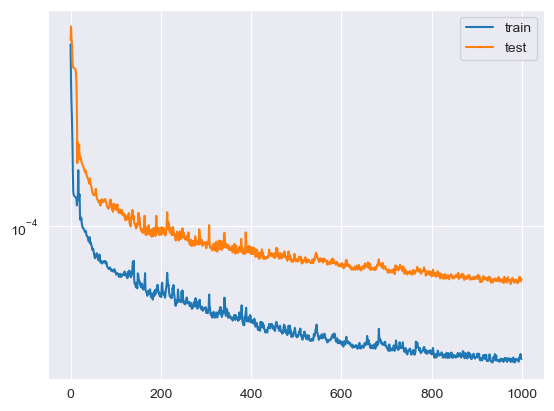

In [35]:
# plot losses in the training and test set on the log scale
plt.plot(train_losses_60_3_layers_64, label='train')
plt.plot(test_losses_60_3_layers_64, label='test')
plt.yscale('log')
plt.legend()
plt.show()

In [36]:
# # extract the encoder part of the autoencoder
encoder_60_4_layers_64 = model_60_3_layers_64.encoder
# # # save the encoder
torch.save(encoder_60_4_layers_64,  'encoder_60_4_layers_64.pt')
# load the encoder
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder_60_4_layers_64 = torch.load('encoder_60_4_layers_64.pt').to(device)

In [37]:
# create environment with the encoder
env = SP500TradingEnvAutoencoder(sp500_df_train, sp500_df_train_not_scaled, window_len=60, encoder=encoder_60_4_layers_64, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [38]:
model_60_4_layers_64 = PPO('MlpPolicy', env, verbose=1)
model_60_4_layers_64.learn(total_timesteps=100000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 500  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.56e+03     |
|    ep_rew_mean          | 1.04         |
| time/                   |              |
|    fps                  | 429          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0047785016 |
|    clip_fraction        | 0.0276       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -6.65        |
|    learning_rate        | 0.0003       |
|    lo

In [39]:
# test the model on the current training data
vec_env = model_60_4_layers_64.get_env()
obs = vec_env.reset()
for i in range(env.end_tick - 1):
    action, _states = model_60_4_layers_64.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render()

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 3
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 4
Portfolio value: [1.0038106]
SP500: [0.8542386]
Cash: [0.14957201]
Done: False
Episode tick: 5
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]
Done: False
Episode tick: 6
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]
Done: False
Episode tick: 7
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]
Done: False
Episode tick: 8
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]
Done: False
Episode tick: 9
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]
Done: False
Episode tick: 10
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]
Done: False
Episode tick: 11
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]
Done: False
Episode tick: 12
Portfolio value: [1.0038106]
SP500: [0.]
Cash: [1.0038106]

In [40]:
# create environment with the encoder and test data
test_env_64 = SP500TradingEnvAutoencoder(sp500_df_test, sp500_df_test_not_scaled, window_len=60, encoder=encoder_60_4_layers_64, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [41]:
# test the model
obs = test_env_64.reset()
for i in range(test_env_64.end_tick - 1):
    action, _states = model_60_4_layers_64.predict(obs)
    obs, rewards, dones, info = test_env_64.step(action)
    test_env_64.render()

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 3
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 4
Portfolio value: [0.99785835]
SP500: [0.25624484]
Cash: [0.7416135]
Done: False
Episode tick: 5
Portfolio value: [1.0071559]
SP500: [1.0071559]
Cash: [0.]
Done: False
Episode tick: 6
Portfolio value: [1.0071559]
SP500: [0.]
Cash: [1.0071559]
Done: False
Episode tick: 7
Portfolio value: [1.0071559]
SP500: [0.]
Cash: [1.0071559]
Done: False
Episode tick: 8
Portfolio value: [1.0068812]
SP500: [0.2912858]
Cash: [0.7155955]
Done: False
Episode tick: 9
Portfolio value: [1.0090129]
SP500: [0.4776815]
Cash: [0.5313314]
Done: False
Episode tick: 10
Portfolio value: [1.0090129]
SP500: [0.]
Cash: [1.0090129]
Done: False
Episode tick: 11
Portfolio value: [1.0090129]
SP500: [0.]
Cash: [1.0090129]
Done: False
Episode tick: 12
Portfolio value: [1.0090129]
SP500: [0.]
Ca